In [1]:
import glob
import time
import warnings

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats, gaussian_sigma_to_fwhm
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.exceptions import AstropyUserWarning
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils import extract_stars, EPSFBuilder, EPSFModel
from photutils import DBSCANGroup, MMMBackground, BasicPSFPhotometry
from photutils import CircularAperture, aperture_photometry

In [2]:
stars_tbl = QTable.read('gaia_catalog.ecsv')
epsf_data = fits.getdata('epsf-v2.fits')
epsf = EPSFModel(epsf_data, oversampling=4.)

In [3]:
star_skycoord = SkyCoord(92.126041, 24.441154, unit='deg', frame='icrs')

In [4]:
times = []
psf_fluxes = []
psf_uncertainties = []
aperture_fluxes = []
residual_fluxes = []

warnings.filterwarnings('ignore', category=AstropyUserWarning)

filepaths = sorted(glob.glob('superstampImages/*'))
for i, filepath in enumerate(filepaths):
    if 'bjd2456768.8805' in filepath:
        continue
        
    start_time = time.time()
    
    hdulist = fits.open(filepath)
    data = hdulist[0].data
    header = hdulist[0].header
    wcs = WCS(header)
    times.append(header['MIDTIME'])
    
    mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)
    bkg = 2.5 * median_val - 1.5 * mean_val
    data -= bkg
    
    grouper = DBSCANGroup(gaussian_sigma_to_fwhm)
    
    #epsf.normalization_correction = 1.0 / (epsf.oversampling[0] ** 2)
    psf_model = epsf
    
    bkg_est = MMMBackground()
    fitter = LevMarLSQFitter()
   
    psf_phot = BasicPSFPhotometry(group_maker=grouper, bkg_estimator=bkg_est,
                                  psf_model=psf_model, fitter=fitter, fitshape=(7, 7),
                                  aperture_radius=3)
    
    xpos, ypos = wcs.world_to_pixel(star_skycoord)
    star_pos = QTable(names=['x_0', 'y_0'], data=[[xpos], [ypos]])

    psf_tbl = psf_phot(data, init_guesses=star_pos)
    psf_fluxes.append(psf_tbl['flux_fit'])
    psf_uncertainties.append(psf_tbl['flux_unc'])
                    
    # perform aperture photometry on the residuals to account for what the model missed
    position = (psf_tbl['x_fit'][0], psf_tbl['y_fit'][0])
    aperture = CircularAperture(position, r=3.)
    
    aper_tbl = aperture_photometry(data, aperture)
    aperture_fluxes.append(aper_tbl['aperture_sum'])
    
    residual_image_star1 = psf_phot.get_residual_image()
    residual_aper_tbl = aperture_photometry(residual_image_star1, aperture)
    residual_fluxes.append(residual_aper_tbl['aperture_sum'])
    
    print(i, time.time() - start_time)

0 0.543630838394165
1 0.18242931365966797
2 0.17327094078063965
3 0.17203116416931152
4 0.17411112785339355
5 0.1727747917175293
6 0.169586181640625
7 0.1713118553161621
8 0.1785449981689453
9 0.1663210391998291
10 0.18015599250793457
11 0.17093706130981445
12 0.1802377700805664
13 0.1722409725189209
14 0.18394112586975098
15 0.17879295349121094
16 0.18547892570495605
17 0.17649388313293457
18 0.17491483688354492
19 0.16972684860229492
20 0.16388607025146484
21 0.1665949821472168
22 0.17425918579101562
23 0.18643927574157715
24 0.17079710960388184
25 0.18217182159423828
26 0.17964696884155273
27 0.16650009155273438
28 0.18002581596374512
29 0.18114304542541504
30 0.1763927936553955
31 0.16865205764770508
32 0.1568896770477295
33 0.17071819305419922
34 0.16619873046875
35 0.16480588912963867
36 0.16931796073913574
37 0.18186402320861816
38 0.18151402473449707
39 0.17888879776000977
40 0.16852831840515137
41 0.16555500030517578
42 0.16945219039916992
43 0.17102909088134766
44 0.169703006

In [5]:
times = Time(times, format='jd', scale='tcb')
psf_fluxes = np.array(psf_fluxes)
psf_uncertainties = np.array(psf_uncertainties)
aperture_fluxes = np.array(aperture_fluxes)
residual_fluxes = np.array(residual_fluxes)

(0.93, 1.05)

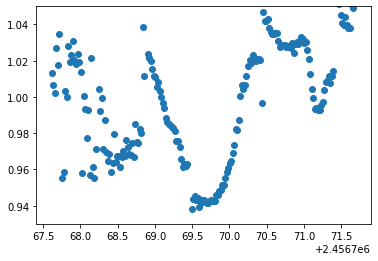

In [6]:
plt.plot(times.jd, psf_fluxes / np.median(psf_fluxes), 'o')
plt.ylim(0.93, 1.05)

(0.96, 1.05)

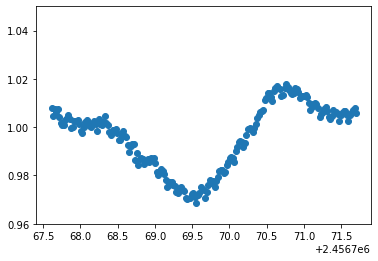

In [7]:
plt.plot(times.jd, aperture_fluxes / np.median(aperture_fluxes), 'o')
plt.ylim(0.96, 1.05)

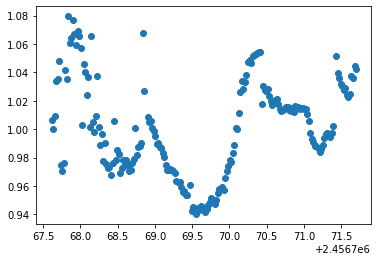

In [8]:
val = psf_fluxes + residual_fluxes
plt.plot(times.jd, val / np.median(val), 'o')

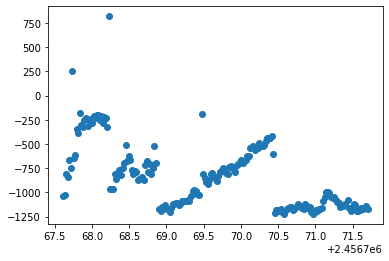

In [9]:
plt.plot(times.jd, residual_fluxes, 'o')